# Appendix B - Non Linear Estimation and Faulty Equipment Classification

## Loading and Training Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [2]:
df = pd.read_csv('Data/Plant_1_Clean.csv')

In [3]:
# choose training data
train_dates = ["2020-05-16", "2020-05-17","2020-05-18" ,"2020-05-19", "2020-05-20", "2020-05-21"]
df_train = df[df["DATES"].isin(train_dates)]

## Defining Non-Linear Function

In [4]:
def func(X, a, b, c, d):
    '''Nonlinear function to predict DC power output from Irradiation and Temperature.'''
    x,y = X#E(t), T(t)
    x=x*1000
    y=y*1000
    return a*x*(1-b*(y+x/800*(c-20)-25)-d*np.log(x+1e-10))

# fit function
p0 = [1.,0.,-1.e4,-1.e-1] # starting values
popt, pcov = curve_fit(func, (df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), df_train.DC_POWER, p0, maxfev=5000)
sigma_abcd = np.sqrt(np.diagonal(pcov))

# predict & save
df_train["Prediction_NL"] = func((df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), *popt)
df_train["Residual_NL"] = df_train["Prediction_NL"] - df_train["DC_POWER"]

df["Prediction_NL"] = func((df.IRRADIATION, df.MODULE_TEMPERATURE), *popt)
df["Residual_NL"] = df["Prediction_NL"] - df["DC_POWER"]

<ipython-input-4-f4408d9065be>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Prediction_NL"] = func((df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), *popt)
<ipython-input-4-f4408d9065be>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Residual_NL"] = df_train["Prediction_NL"] - df_train["DC_POWER"]


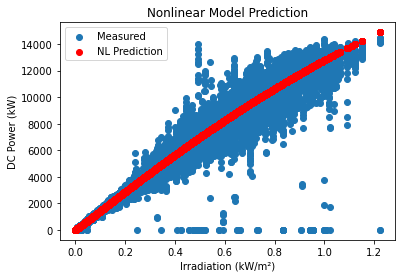

In [5]:
plt.scatter(df.IRRADIATION, df.DC_POWER, label="Measured")
plt.scatter(df.IRRADIATION, df.Prediction_NL, color="r", label="NL Prediction")
plt.legend()
plt.xlabel("Irradiation (kW/m²)")
plt.ylabel("DC Power (kW)")
plt.title("Nonlinear Model Prediction")
plt.show()

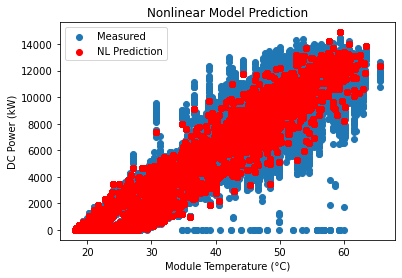

In [6]:
plt.scatter(df.MODULE_TEMPERATURE, df.DC_POWER, label="Measured")
plt.scatter(df.MODULE_TEMPERATURE, df.Prediction_NL, color="r", label="NL Prediction")
plt.legend()
plt.xlabel("Module Temperature (°C)")
plt.ylabel("DC Power (kW)")
plt.title("Nonlinear Model Prediction")
plt.show()

### Parameter Estimates and Signal to Noise

In [7]:
popt

array([ 1.11066843e+01, -8.30279162e-10, -2.90893800e+08, -6.56017151e-02])

In [8]:
(popt / sigma_abcd).astype(float)

array([ 2.04447912e+01, -2.93911876e-03, -2.95693986e-03, -5.24375084e+00])

### Calculating Residuals and Coming Up w/ Threshold for Classifying Faults

In [9]:
resids = df.Prediction_NL - df.DC_POWER

In [10]:
iqr = resids.quantile(0.75) - resids.quantile(0.25)

upperfence = resids.quantile(0.75) + 3*iqr
upperfence

faultdf = df[resids > 5000 ]
nonfaultdf = df[(resids <= 5000) ]

In [11]:
faultdf.to_csv('Data/faulty.csv')

In [12]:
faultdf.shape

(82, 14)

In [13]:
faultdf.SOURCE_KEY.value_counts()

1BY6WEcLGh8j5v7    23
bvBOhCH3iADSZry    23
z9Y9gH1T5YWrNuG     8
wCURE6d3bPkepu2     7
McdE0feGgRqW7Ca     7
sjndEbLyjtCKgGv     5
zBIq5rxdHJRwDNY     3
uHbuxQJl8lW7ozc     1
ih0vzX44oOqAx2f     1
VHMLBKoKgIrUVDU     1
rGa61gmuvPhdLxV     1
pkci93gMrogZuBj     1
7JYdWkrLSPkdwr4     1
Name: SOURCE_KEY, dtype: int64

In [14]:
faultdf.describe()

,Unnamed: 0,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Prediction_NL,Residual_NL
count,82.000000,82.0,82.000000,82.000000,82.000000,8.200000e+01,82.000000,82.000000,82.000000,82.000000,82.000000
mean,49298.768293,4135001.0,884.252831,86.397125,3226.540723,6.749501e+06,28.427553,50.547176,0.772513,10190.528142,9306.275311
std,12967.318944,0.0,1967.500697,192.150720,1011.282435,3.606795e+05,1.832779,7.796285,0.215521,2478.742175,2758.308371
min,11976.000000,4135001.0,0.000000,0.000000,1280.857143,6.258289e+06,24.932560,34.780682,0.406296,5737.528259,5035.275684
25%,46725.500000,4135001.0,0.000000,0.000000,2389.968750,6.466065e+06,27.048904,45.547812,0.591769,8150.855964,6866.400713
50%,46795.500000,4135001.0,0.000000,0.000000,3551.000000,6.520020e+06,28.884908,53.509308,0.783414,10440.270900,8983.796284
75%,61435.250000,4135001.0,429.281250,42.121875,4021.000000,7.181310e+06,29.951886,56.895085,0.954715,12320.832060,12202.754099
max,65737.000000,4135001.0,8479.428571,828.700000,6464.000000,7.645856e+06,33.761304,59.987771,1.221652,14891.731663,14891.731663


### Plotting Faulty Classifications

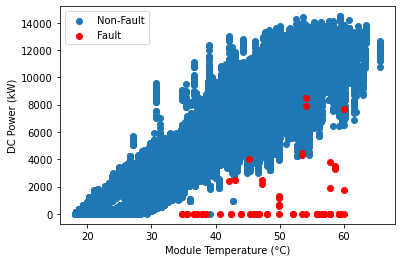

In [15]:
plt.scatter(nonfaultdf.MODULE_TEMPERATURE, nonfaultdf.DC_POWER,  label="Non-Fault")
plt.scatter(faultdf.MODULE_TEMPERATURE, faultdf.DC_POWER, label="Fault",color="r")
plt.legend()
plt.xlabel("Module Temperature (°C)")
plt.ylabel("DC Power (kW)")
plt.savefig('Plots/suboptimal.png', dpi = 600)
plt.show()


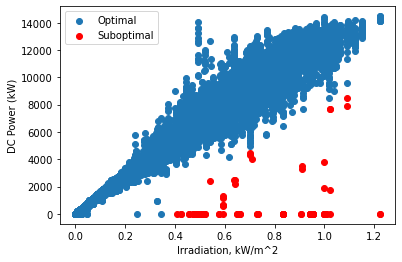

In [16]:
plt.scatter(nonfaultdf.IRRADIATION, nonfaultdf.DC_POWER,  label="Optimal")
plt.scatter(faultdf.IRRADIATION, faultdf.DC_POWER, label="Suboptimal",color="r")
plt.legend()
plt.xlabel("Irradiation, kW/m^2")
plt.ylabel("DC Power (kW)")
plt.savefig('Plots/suboptimal.png', dpi = 600)
plt.show()

In [17]:
df.describe()

,Unnamed: 0,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Prediction_NL,Residual_NL
count,68774.000000,68774.0,68774.000000,68774.000000,68774.000000,6.877400e+04,68774.000000,68774.000000,68774.000000,68774.000000,68774.000000
mean,34387.500000,4135001.0,3147.177450,307.778375,3295.834644,6.978728e+06,25.558521,31.244997,0.232305,3163.865830,16.688380
std,19853.488044,0.0,4036.441826,394.394865,3145.220597,4.162707e+05,3.361300,12.308283,0.301948,4032.030214,548.550418
min,1.000000,4135001.0,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000,-0.000000,-7111.349441
25%,17194.250000,4135001.0,0.000000,0.000000,0.000000,6.512007e+06,22.724491,21.123944,0.000000,-0.000000,-31.346192
50%,34387.500000,4135001.0,428.571429,41.450000,2658.473214,7.146685e+06,24.670178,24.818984,0.031620,427.415207,-0.000000
75%,51580.750000,4135001.0,6365.468750,623.561161,6274.000000,7.268751e+06,27.960429,41.693659,0.454880,6386.950755,3.997220
max,68774.000000,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06,35.252486,65.545714,1.221652,14891.731663,14891.731663


## Running Non Linear Fit on Each Day

In [18]:
p0 = [1.,0.,-1.e4,-1.e-1] # starting values
paramdf = pd.DataFrame()

for d in df.DATES.unique():
    ddf = df[df.DATES == d]
    popt, pcov = curve_fit(func, (ddf.IRRADIATION, ddf.MODULE_TEMPERATURE), ddf.DC_POWER, p0, maxfev=100000)
    
    dfa = pd.DataFrame({'a':[popt[0]], 'b': [popt[1]], 'c':[popt[2]], 'd':[popt[3]]})
    paramdf = paramdf.append(dfa)



In [19]:
paramdf.to_csv('Data/nonlinearparamsestimates.csv', index = False)